# Sovling Diffusion Equation with PINN

Diffusion Equation: 

$$u_t = u_xx - e^{-t}(\sin(\pi x) - \pi^2\sin(\pi x)) \quad x \in [-1, 1], t\in [0, 1]$$

Initial Condition: $$u(x, 0) = \sin(\pi x)$$
Boudary Conditions: $$u(-1, t) = u(1, t) = 0$$
Exact solution: $$u(x, t) = e^{-t}\sin(\pi x)$$

In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
class Layer:
    """
    Define the structure of every layer.
    
    Paras:
      input_dim: size of input dataset
      output_dim: number of neurons
      activation: activation function, default: None(i.e. without activation function)
      
    Properties:
      activation: activation function
      W, b: weights of the layer
      weights: a list that contains W and b
      
    You can just call a layer to execute the progress called "forward pass"
    """
    def __init__(self, input_dim, output_dim, activation=None):
        self.activation = activation
        
        # initial weights
        std = np.sqrt(2 / (input_dim + output_dim))
        self.W = tf.Variable(initial_value=tf.random.normal(shape=(input_dim, output_dim), stddev=std))
        self.b = tf.Variable(initial_value=tf.zeros(shape=(output_dim, )))
        
    def __call__(self, inputs):
        # forward pass
        if self.activation:
            return self.activation(tf.matmul(inputs, self.W) + self.b)
        else:
            # If the layer don't have an activation, go linear combination directly
            return tf.matmul(inputs, self.W) + self.b
        
    @property
    def weights(self):
        # define "weight" property
        return [self.W, self.b]

class Model:
    """
    Define the model
    
    Paras:
      layers: a list of Layer
      xmin, xmax: the range of the PDE
      
    Properties:
      layers: a list of Layer
      train_min, train_max: the range of the PDE
      weights: a list that contains weights of each layer
      
    You can call the model to calculate the result based on given dataset
    """
    def __init__(self, layers, train_min, train_max):
        self.layers = layers
        self.train_min = train_min
        self.train_max = train_max
        
    def __call__(self, training_set):
        x = training_set
        x = 2.0 * (x - self.train_min) / (self.train_max - self.train_min) - 1.0
        for layer in self.layers:
            # update inputs
            x = layer(x)
        return x
    
    @property
    def weights(self):
        # 将所有layer的参数整合在一起
        weights = []
        for layer in self.layers:
            weights += layer.weights
        return weights

In [3]:
def train_step(model, optimizer, X_train, X_train_IC, 
               X_train_BC_bottom, X_train_BC_top, w1=1, w2=1):
    """
    One training step using SGD.
    
    Params:
      model: an NN/DNN model
      optimizer: a Keras optimizer
      X_train: training set for the pde
      X_train_IC: training set for initial condition
      X_train_BC_bottom, X_train_BC_top: training set for boundary condition
      w1, w2: weights for pde loss and IC/BC loss
      
    Return: 
      loss: loss score after training
    """
    
    # Calculate loss
    with tf.GradientTape() as utter_tape:
        with tf.GradientTape(persistent=True) as outer_tape:
            with tf.GradientTape(persistent=True) as inner_tape:
                x = X_train[:, 0]
                t = X_train[:, 1]
                # tf.stack([x, t], axis=1) <=> X_train
                u = model(tf.stack([x, t], axis=1))
            u_x = inner_tape.gradient(u, x)
            u_t = inner_tape.gradient(u, t)
        u_xx = outer_tape.gradient(u_x, x)
    
        f = -tf.exp(-t) * (tf.sin(np.pi * x) - np.pi**2 * tf.sin(np.pi * x))

        # loss of the PDE
        loss_f = tf.reduce_mean(tf.square(u_t - u_xx - f))

        # loss of IC
        u_pred_IC = model(X_train_IC)
        u_IC = np.sin(np.pi * X_train_IC[:, 0])[:, None]
        loss_IC = tf.reduce_mean(tf.square(u_pred_IC - u_IC))

        # loss of BCs
        u_pred_BC_bottom = model(X_train_BC_bottom)
        u_pred_BC_top = model(X_train_BC_top)
        loss_BC_bottom = tf.reduce_mean(tf.square(u_pred_BC_bottom - 0))
        loss_BC_top = tf.reduce_mean(tf.square(u_pred_BC_top - 0))

        # total loss
        loss = w1 * loss_f + w2 * (loss_IC + loss_BC_bottom + loss_BC_top)

    # optimize with optimizer
    optimizer.minimize(loss, model.weights, tape=utter_tape)
    return loss

def train_model(model, X_train, X_train_IC, 
               X_train_BC_bottom, X_train_BC_top, w1=1, w2=1, epochs=1000, learning_rate=0.0008, warning=False):
    """
    Train neural network model.
    
    Paras: 
      model: a neural network model
      X_train: training set for the pde
      X_train_IC: training set for initial condition
      X_train_BC_bottom, X_train_BC_top: training set for boundary condition
      w1, w2: weights for pde loss and IC/BC loss
      epochs: epochs, i.e. times of training, default: 1000
      learning_rate: learning rate of SGD, default: 0.0008
      warning: whether to show loss score of each epoch, default: False
      
    Return value:
      history_loss: a list that contains loss score at each step
    """
    
    history_loss = []
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    for epoch in range(epochs):
        loss = train_step(model, optimizer, X_train, X_train_IC, X_train_BC_bottom, X_train_BC_top, w1, w2)
        history_loss.append(loss)
        if warning:
            print(f'epoch: {epoch + 1}, loss: {loss:.5f}')  
            
    return history_loss

In [4]:
def u_exact(x, t):
    """
    Exact solution of the pde
    """
    return tf.exp(-t) * tf.sin(np.pi * x);

# Training Data

In [5]:
# Training data for pde
xmin = -1.0
xmax = 1.0
tmin = 0
tmax = 1.0
pde_point_count = 800

x = xmin + (xmax - xmin) * np.random.rand(pde_point_count, 1)
t = tmin + (tmax - tmin) * np.random.rand(pde_point_count, 1)

X_train = tf.Variable(np.hstack((x, t)), dtype='float32')
train_min = np.hstack((xmin, tmin))
train_max = np.hstack((xmax, tmax))

# Training data for initial condition
ic_point_count = 100

b_x = xmin + (xmax - xmin) * np.random.rand(ic_point_count, 1)
X_train_IC = tf.Variable(np.hstack((b_x, np.zeros_like(b_x))), dtype='float32')

# Training data for boundary conditions
bc_point_count_each = 100

b_t = tmin + (tmax - tmin) * np.random.rand(bc_point_count_each, 1)
X_train_BC_bottom = tf.Variable(np.hstack((np.ones_like(b_t) * xmin, b_t)), dtype="float32")
X_train_BC_top = tf.Variable(np.hstack((np.ones_like(b_t) * xmax, b_t)), dtype="float32")

In [6]:
# DNN model
model = Model([
    Layer(input_dim=2, output_dim=32, activation=tf.nn.tanh),
    Layer(input_dim=32, output_dim=64, activation=tf.nn.tanh),
    Layer(input_dim=64, output_dim=32, activation=tf.nn.tanh),
    Layer(input_dim=32, output_dim=1, activation=None)
], train_min, train_max)

Streaming output truncated to the last 5000 lines.
epoch: 5001, loss: 0.00038
epoch: 5002, loss: 0.00038
epoch: 5003, loss: 0.00038
epoch: 5004, loss: 0.00038
epoch: 5005, loss: 0.00038
epoch: 5006, loss: 0.00038
epoch: 5007, loss: 0.00038
epoch: 5008, loss: 0.00038
epoch: 5009, loss: 0.00038
epoch: 5010, loss: 0.00038
epoch: 5011, loss: 0.00038
epoch: 5012, loss: 0.00038
epoch: 5013, loss: 0.00038
epoch: 5014, loss: 0.00038
epoch: 5015, loss: 0.00038
epoch: 5016, loss: 0.00038
epoch: 5017, loss: 0.00038
epoch: 5018, loss: 0.00038
epoch: 5019, loss: 0.00038
epoch: 5020, loss: 0.00038
epoch: 5021, loss: 0.00038
epoch: 5022, loss: 0.00038
epoch: 5023, loss: 0.00038
epoch: 5024, loss: 0.00038
epoch: 5025, loss: 0.00038
epoch: 5026, loss: 0.00038
epoch: 5027, loss: 0.00038
epoch: 5028, loss: 0.00038
epoch: 5029, loss: 0.00038
epoch: 5030, loss: 0.00038
epoch: 5031, loss: 0.00038
epoch: 5032, loss: 0.00038
epoch: 5033, loss: 0.00038
epoch: 5034, loss: 0.00038
epoch: 5035, loss: 0.00038
epoc

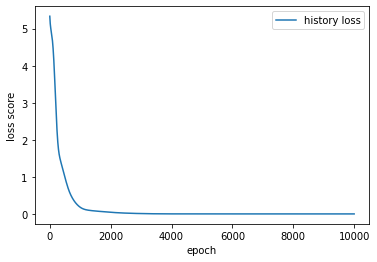

Final loss score: 6.896544073242694e-05


In [7]:
# train the model
epochs = 10000
history_loss = train_model(model, X_train, X_train_IC, X_train_BC_bottom, X_train_BC_top,
                           w1=0.3, w2=0.8, epochs=epochs,
                          learning_rate=1e-4, warning=True)

# plot loss score in each epoch
plt.plot(np.array(range(epochs)) + 1, history_loss, label='history loss')
plt.xlabel('epoch')
plt.ylabel('loss score')
plt.legend()
plt.show()
plt.close()

print(f'Final loss score: {history_loss[-1]}')

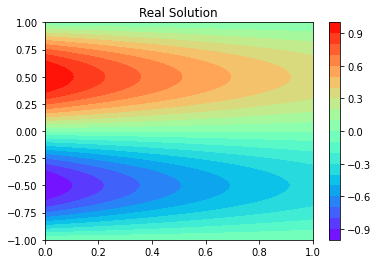

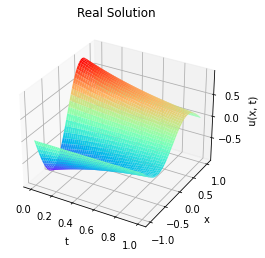

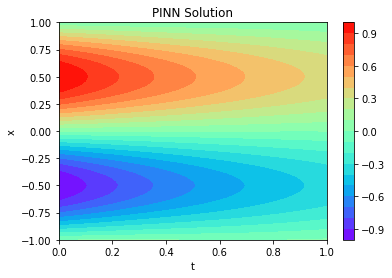

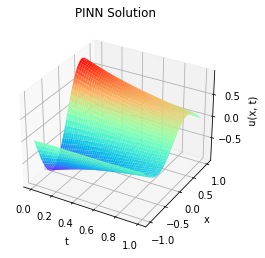

In [11]:
# plot results

x_test = np.linspace(-1, 1, 200).reshape((-1, 1))
t_test = np.linspace(0, 1, 200).reshape((-1, 1))
x_t, t_t = np.meshgrid(x_test, t_test)
u_real = u_exact(x_t, t_t)

# real solution
fig, ax = plt.subplots(1, 1)
cp = ax.contourf(t_t, x_t, u_real, 20, cmap="rainbow")
ax.set_label('t')
ax.set_label('x')
ax.set_title('Real Solution')
fig.colorbar(cp)
plt.show()

ax = plt.axes(projection='3d')
ax.plot_surface(t_t, x_t, u_real.numpy(), cmap='rainbow')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u(x, t)')
ax.set_title('Real Solution')
plt.show()

# PINN solution

X_test = tf.Variable(np.hstack((x_t.reshape((-1, 1)), t_t.reshape((-1, 1)))), dtype="float32")
u_pred = model(X_test)
u_pred = tf.reshape(u_pred, (200, 200))

fig, ax = plt.subplots(1, 1)
cp = ax.contourf(t_t, x_t, u_pred, 20, cmap="rainbow")
fig.colorbar(cp)
ax.set_title('PINN Solution')
ax.set_xlabel('t')
ax.set_ylabel('x')
plt.show()

ax = plt.axes(projection='3d')
ax.plot_surface(t_t, x_t, u_pred.numpy(), cmap='rainbow')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u(x, t)')
ax.set_title('PINN Solution')
plt.show()